In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pickle


2024-06-11 22:54:13.338195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-11 22:54:13.338848: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/dia/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
"tf_flowers",
split=['train[:10%]', "train[10%:25%]", "train[25%:]"],
as_supervised=True,
with_info=True)

2024-06-11 22:54:39.036697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-11 22:54:39.039499: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-11 22:54:39.040553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-H0J11JO): /proc/driver/nvidia/version does not exist
2024-06-11 22:54:39.062976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
test_set_raw

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

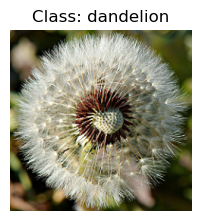

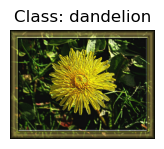

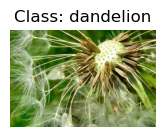

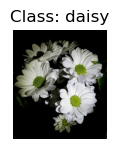

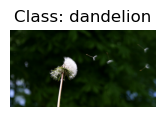

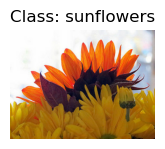

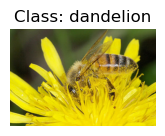

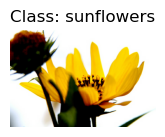

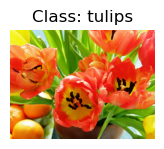

2024-06-11 22:54:41.361243: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9)
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
    plt.show(block=False)

In [5]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

In [6]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)


<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


2024-06-11 22:54:51.621777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2053 of 3670
2024-06-11 22:55:01.870273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2522 of 3670
2024-06-11 22:55:07.232995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2024-06-11 22:55:08.695474: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2024-06-11 22:55:09.526445: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


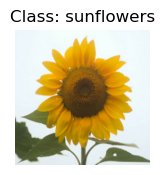

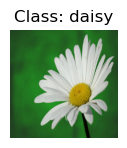

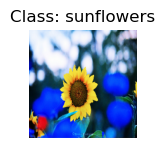

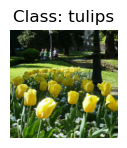

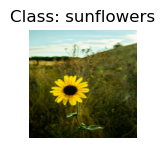

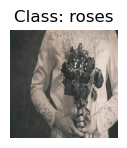

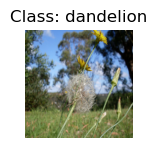

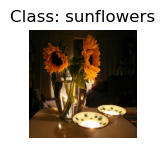

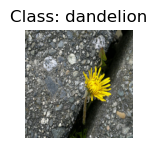

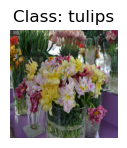

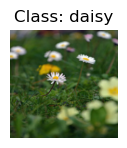

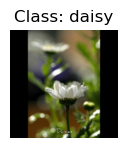

In [7]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
print(sample_batch)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
        plt.show()


In [10]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))

2024-06-11 23:08:50.196585: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2024-06-11 23:08:50.285124: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2024-06-11 23:08:50.355760: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=["accuracy"])
model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10


2024-06-11 23:10:21.354317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 795 of 3670
2024-06-11 23:10:31.630766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2012 of 3670
2024-06-11 23:10:40.552656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


76/86 [=========================>....] - ETA: 1:06 - loss: nan - accuracy: 0.2393

In [ ]:
acc_train = model.evaluate(train_set)[1]
acc_valid = model.evaluate(valid_set)[1]
acc_test = model.evaluate(test_set)[1]

print((acc_train, acc_valid, acc_test))

In [ ]:
with open("simple_cnn_acc.pkl", 'wb') as f:
    pickle.dump((acc_train, acc_valid, acc_test), f)

model.save("simple_cnn_flowers.keras")

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32

train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)

for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
plt.show()

In [ ]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=0.2), metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

In [ ]:
base_model.trainable = True
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), metrics=["accuracy"])
model.fit(train_set, epochs=3, validation_data=valid_set)


In [ ]:
acc_train = model.evaluate(train_set)[1]
acc_valid = model.evaluate(valid_set)[1]
acc_test = model.evaluate(test_set)[1]

with open("xception_acc.pkl", 'wb') as f:
    pickle.dump((acc_train, acc_valid, acc_test), f)

model.save("xception_flowers.keras")